# Vision Transformer (ViT)  en TensorFlow

Primero importamos las librerias

In [101]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from transformers import AutoImageProcessor, TFAutoModel # Trabajaremos con TensorFlow. Originalmente es con PyTorch. AutoModel solo carga el modelo y pesos, pero no la capa classifier.
from PIL import Image
import os

In [102]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# Carga de imagenes.

In [103]:
# Vamos a cargar las imagenes.
# Declaramos el path
path_training = "./brain_dataset/Training" # Primero con las imagnees del Training
images = []
labels = []

In [104]:
# Ahora procedemos con hacer un for.
for label_name in os.listdir(path_training): # Recorre todos los labels del folder dentro.
    folder = os.path.join(path_training, label_name) # Juntamos la ruta para acceder a ese label.
    # En caso no sea un folder, ignorarlo
    if not os.path.isdir(folder):
        continue 
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename) # La ruta de la imagen misma.
        image = Image.open(img_path).convert("RGB") # El modelo pre-entrenado fue hecho por RGB. Es necesario convertirlo
        images.append(image)
        labels.append(label_name)

In [105]:
# Los labels se encuentran en strings, debemos de codificarlos.
from sklearn.preprocessing import LabelEncoder

# Convertir labels de strings a números
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)  # ['glioma', 'meningioma'] → [0, 1, ...]
# Lo usaremos luego para el testing

In [106]:
# Ya tenemos cargada las imagenes, procedemos con el preprocesamiento.
# Este preprocesamiento proviene de la libreria transformers.
inputs_values = processor(images=images, return_tensors="tf") # Esto para que devuelva en formato de tensores pero de TensorFlow
print(inputs_values["pixel_values"].shape)  # (N, 3, 224, 224)


(5712, 3, 224, 224)


# Para visualizar imagen de manera aleatoria

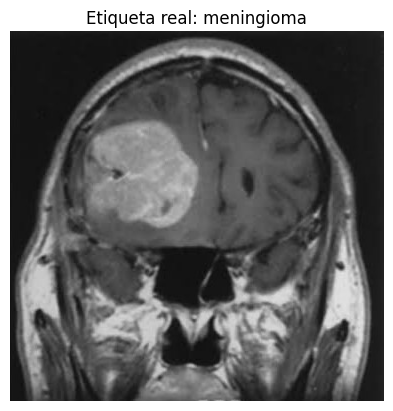

In [107]:
import random
import matplotlib.pyplot as plt

# Elegir un índice aleatorio
idx = random.randint(0, len(images) - 1)
random_image = images[idx]
random_label = labels[idx]


plt.imshow(random_image)
plt.axis("off")  # Quitar ejes
plt.title(f"Etiqueta real: {random_label}")
plt.show()


# Ahora cargamos el modelo.

In [108]:
backbone = TFAutoModel.from_pretrained("facebook/deit-tiny-patch16-224")

Some layers from the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cuenta con dos partes: 
- Base/Backbone (DeiT Transformer -> Se congela)
- Classifier Head (A reemplazar)

In [109]:
# Lo que haremos es congelar entonces el backbone.
backbone.trainable = False
for layer in backbone.layers:
    layer.trainable = False

- DeiT usa patches de 16x16 pxs. Por tanto, como las imagenes son de 224 x 224 => 224 / 16 = 14 => 14 x 14 = 196 patches por imagen.

In [110]:
num_classes = 4

# Modelo custom
inputs = Input(shape=(224, 224, 3))

# Transformar de (B, 224,224,3) → (B,3,224,224) y pasar por el modelo
x = Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]))(inputs) # Lambda permite que el grafo de Keras no se rompa.
x = Lambda(lambda x: backbone(pixel_values=x).last_hidden_state[:, 0, :])(x) # Esto extrae el token CLS que esta inicial de todos los patches (el embedding global)

# Clasificador custom según el paper
x = Dense(2048, activation='relu', name='hidden_layer')(x)
x = Dropout(0.3, name='dropout_layer')(x)
outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

# Crear modelo
model = Model(inputs=inputs, outputs=outputs, name='DeiT_Classifier')

# Compilar según especificaciones del paper
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "DeiT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 2048)           │       395,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,460 (1.54 MB)

 Trainable params: 403,460 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
print(f"Total params: {model_custom.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model_custom.trainable_weights]):,}")
print(f"Non-trainable params: {sum([tf.size(w).numpy() for w in backbone.weights]):,}")

Total params: 25,220
Trainable params: 25,220
Non-trainable params: 5,561,472


# Procedemos en convertir las imagenes en numpy array

In [112]:
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
import tensorflow as tf

batch_size = 48
# Convierte en un tf.data.Dataset directamente (no ocupa toda la RAM)
X = tf.convert_to_tensor(inputs_values["pixel_values"], dtype=tf.float32)
X = tf.transpose(X, [0, 2, 3, 1])  # (N, 224, 224, 3)
y = tf.convert_to_tensor(labels_numeric, dtype=tf.int32)

dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Ahora entrenamos

In [114]:
history = model.fit(dataset, epochs=30)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 452ms/step - accuracy: 0.8155 - loss: 0.9919
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 432ms/step - accuracy: 0.6126 - loss: 1.6891
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 398ms/step - accuracy: 0.7305 - loss: 0.8921
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 398ms/step - accuracy: 0.7546 - loss: 0.8017
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 389ms/step - accuracy: 0.7637 - loss: 0.7543
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.7653 - loss: 0.7137
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.7701 - loss: 0.6859
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 372ms/step - accuracy: 0.7726 - loss: 0.6582
Epoch 9/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.7807 - loss: 0.6241
Epoch 10/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 62s 348ms/step - accuracy: 0.7942 - loss: 0.5999
Epoch 11/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 60s 335ms/step - accuracy: 0.8002 - loss: 0.5728
Epoch 12/30
179/179

# Probamos con el Test

In [117]:
# Cuando termines el entrenamiento, carga el test set:
path_testing = "./brain_dataset/Testing"
images_test = []
labels_test = []

for label_name in os.listdir(path_testing):
    folder = os.path.join(path_testing, label_name)
    if not os.path.isdir(folder):
        continue
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = Image.open(img_path).convert("RGB")
        images_test.append(image)
        labels_test.append(label_name)

# Preprocesar
inputs_test = processor(images=images_test, return_tensors="tf")
X_test = np.array(inputs_test["pixel_values"])
X_test = tf.transpose(X_test, [0, 2, 3, 1])
y_test = label_encoder.transform(labels_test)  # Usar el MISMO encoder

print(f"Test set: {X_test.shape[0]} imágenes")

Test set: 1311 imágenes


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Convertir a tensores
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)


# Dataset eficiente
batch_size = 48
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Evaluar desempeño general
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

# Obtener predicciones
y_pred_logits = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_logits, axis=1)

# Reporte detallado
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.7105 - loss: 0.8975

✅ Test accuracy: 0.8238 | loss: 0.5299
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step

📊 Classification report:
              precision    recall  f1-score   support

      glioma       0.98      0.59      0.74       300
  meningioma       0.68      0.67      0.67       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.74      1.00      0.85       300

    accuracy                           0.82      1311
   macro avg       0.84      0.81      0.81      1311
weighted avg       0.84      0.82      0.82      1311

